Pablo Mata Aroco

In [ ]:
appname = "Hack_data assignment"

# Look into https://spark.apache.org/downloads.html for the latest version
spark_mirror = "https://mirrors.sonic.net/apache/spark"
spark_version = "3.3.1"
hadoop_version = "3"

# Install Java 8 (Spark does not work with newer Java versions)
! apt-get update
! apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and extract Spark binary distribution
! rm -rf spark-{spark_version}-bin-hadoop{hadoop_version}.tgz spark-{spark_version}-bin-hadoop{hadoop_version}
! wget -q {spark_mirror}/spark-{spark_version}/spark-{spark_version}-bin-hadoop{hadoop_version}.tgz
! tar xzf spark-{spark_version}-bin-hadoop{hadoop_version}.tgz

# The only 2 environment variables needed to set up Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/spark-{spark_version}-bin-hadoop{hadoop_version}"

# Set up the Spark environment based on the environment variable SPARK_HOME 
! pip install -q findspark
import findspark
findspark.init()

# Get the Spark session object (basic entry point for every operation)
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName(appname).master("local[*]").getOrCreate()

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://archive.ubuntu.co

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark import SparkFiles
spark.sparkContext.addFile('/content/drive/MyDrive/Colab Notebooks/hack_data.csv')
data = spark.read.option("header","true").csv('/content/drive/MyDrive/Colab Notebooks/hack_data.csv')

data.show(5)
data.summary().show()

+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|            Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------------------+----------------+
|                    8.0|           391.09|              1|             2.96|            7.0|            Slovenia|           72.37|
|                   20.0|           720.99|              0|             3.04|            9.0|British Virgin Is...|           69.08|
|                   31.0|           356.32|              1|             3.71|            8.0|             Tokelau|           70.58|
|                    2.0|           228.08|              1|             2.48|            8.0|             Bolivia|            70.8|
|                   20.0|            408.5|              0|             3.57

In [ ]:
data.printSchema()

root
 |-- Session_Connection_Time: string (nullable = true)
 |-- Bytes Transferred: string (nullable = true)
 |-- Kali_Trace_Used: string (nullable = true)
 |-- Servers_Corrupted: string (nullable = true)
 |-- Pages_Corrupted: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: string (nullable = true)



Looking for Nan or Null values

In [ ]:
from pyspark.sql.functions import *

data.select([count(when(isnan(x) | col(x).isNull(), x)).alias(x) for x in data.columns]
   ).show()

Transforming all the data to numeric (except location)

In [ ]:
data2 = data
for y in data2.columns[0:5]:
  data2=data2.withColumn(y,col(y).cast("float"))
data2=data2.withColumn("WPM_Typing_Speed", col("WPM_Typing_Speed").cast("float"))
data2.printSchema()

root
 |-- Session_Connection_Time: float (nullable = true)
 |-- Bytes Transferred: float (nullable = true)
 |-- Kali_Trace_Used: float (nullable = true)
 |-- Servers_Corrupted: float (nullable = true)
 |-- Pages_Corrupted: float (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: float (nullable = true)



Creating pipeline for analysis

In [ ]:
from pyspark.ml.feature import (StringIndexer, OneHotEncoder)

hack_indexer = StringIndexer(inputCol='Location', outputCol='Location_index')
hack_encoder = OneHotEncoder(inputCol='Location_index', outputCol='Location_encoded')

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['Session_Connection_Time','Bytes Transferred',
                                       'Kali_Trace_Used','Servers_Corrupted',
                                       'Pages_Corrupted','Location_encoded','WPM_Typing_Speed'],
                            outputCol='features')

In [ ]:
from pyspark.ml.feature import RobustScaler

rbscaler = RobustScaler(inputCol='features', outputCol='scaled_features')

In [ ]:
from pyspark.ml.feature import StandardScaler

stscaler = StandardScaler(inputCol='features', outputCol='scaled_features')

Testing and evaluating K-means clustering with different k

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

for i in range(2,8):
  kmeans = KMeans(featuresCol='scaled_features', k=i)

  pipeline = Pipeline(stages=[hack_indexer, hack_encoder, assembler, rbscaler, kmeans])

  model = pipeline.fit(data2)

  final_data = model.transform(data2)

  evaluator = ClusteringEvaluator(metricName='silhouette', distanceMeasure='squaredEuclidean',featuresCol="scaled_features", predictionCol="prediction")

  silhouette = evaluator.evaluate(final_data)
  print("Silhouette = " + str(silhouette) + "With k = " + str(i))


Silhouette = 0.8202457932959083With k = 2
Silhouette = 0.7335267640693157With k = 3
Silhouette = 0.6581601894308585With k = 4
Silhouette = 0.5990174076668996With k = 5
Silhouette = 0.5304763963868883With k = 6
Silhouette = 0.5245532811000728With k = 7


Best results were obtained with k=2 using Silhouette Score as the main metric

In [ ]:
kmeans = KMeans(featuresCol='scaled_features', k=2)

pipeline = Pipeline(stages=[hack_indexer, hack_encoder, assembler, rbscaler, kmeans])

model = pipeline.fit(data2)

final_data = model.transform(data2)

Since its a multidimensional dataset. I plotted one pair of features at a time.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np

pdata = final_data.toPandas()

Text(0.5, 0.98, 'Hack_data clusters with k=2')

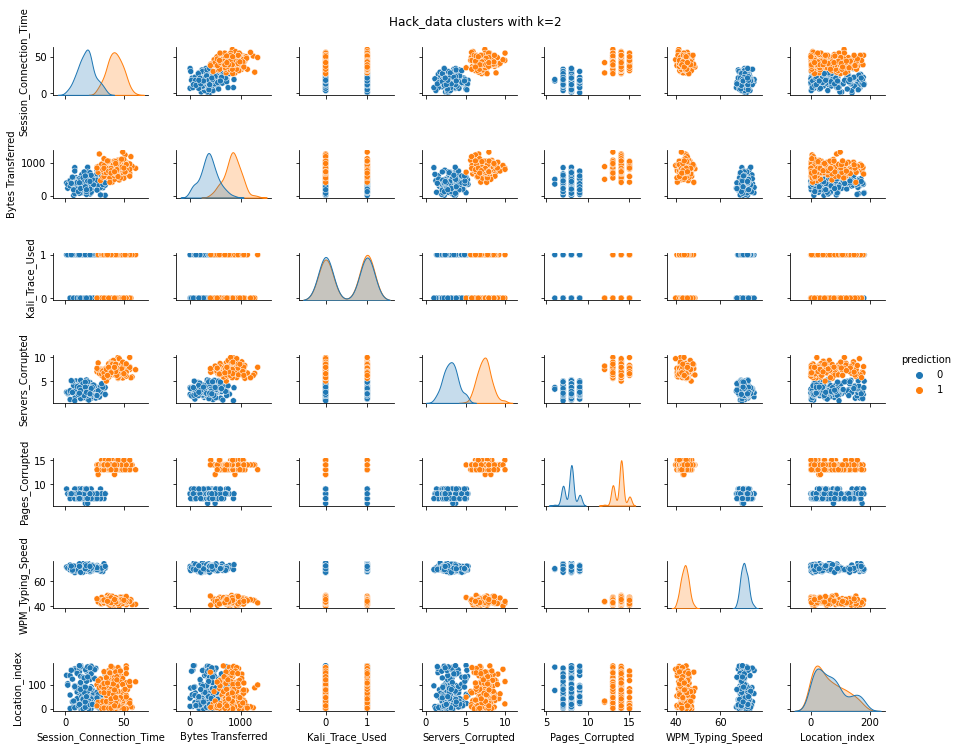

In [ ]:
sns.pairplot(pdata, hue="prediction", height=1.5, aspect=1.2).fig.suptitle('Hack_data clusters with k=2')

In [ ]:
ClusteringEvaluator().explainParams()

"distanceMeasure: The distance measure. Supported options: 'squaredEuclidean' and 'cosine'. (default: squaredEuclidean)\nfeaturesCol: features column name. (default: features)\nmetricName: metric name in evaluation (silhouette) (default: silhouette)\npredictionCol: prediction column name. (default: prediction)\nweightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)"